In [1]:
import torch
import torch.nn as nn
import math



In [2]:

def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)




In [3]:
model_urls = {
    'resnet18': '/app/workspace/model/resnet18-5c106cde.pth'
}


In [4]:
# reference : https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x


def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    if pretrained:
        pretrained_model = torch.load(model_urls['resnet18'])
        model.load_state_dict(pretrained_model)
    return model


In [5]:
res18 = resnet18(pretrained=True)

In [6]:
from IPython.core.display import display
from IPython.core.display import Image as Image2
from torchvision import models, transforms
from torch.autograd import Variable
import torch.nn as nn
import numpy as np
from PIL import Image
import requests

from io import BytesIO

### eval 모드 
 * 모델을 사용하기전에는 eval() 모드를 호출해줘야한다.

In [7]:
_ = res18.eval()

### 이미지 분류기 테스트 
 * 각 이미지별로 어떤 카테고리로 분류하는지 테스트한다.

In [8]:
trans = transforms.Compose([
    transforms.Scale(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # from http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
])

url = 'https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/' \
      'raw/596b27d23537e5a1b5751d2b0481ef172f58b539/imagenet1000_clsid_to_human.txt'

imagenet_classes = eval(requests.get(url).content)

images = [('cat', 'https://www.wired.com/wp-content/uploads/2015/02/catinbox_cally_by-helen-haden_4x31-660x495.jpg'),
          ('pomeranian', 'https://c.photoshelter.com/img-get/I0000q_DdkyvP6Xo/s/900/900/Pomeranian-Dog-with-Ball.jpg'),
          ('car', 'https://www.autocar.co.uk/sites/autocar.co.uk/files/styles/gallery_slide/public/images/car-reviews/first-drives/legacy/porsche-911_0.jpg')]
# images = [('shoes','http://thum.buzzni.com/unsafe/320x320/center/smart/http://172.16.10.6/maestro_img/query/query_21.jpg')]

for class_name, image_url in images:
    print(class_name)
    response = requests.get(image_url)
    im = Image.open(BytesIO(response.content))
    tens = Variable(trans(im))
    tens = tens.view(1, 3, 224, 224)
    preds = nn.LogSoftmax()(res18(tens)).data.cpu().numpy()
    res = np.argmax(preds)
    print('true (likely) label:', class_name)
    print('predicted', imagenet_classes[res], '\n')
    display(Image2(url=image_url,width=100))


/home/user/miniconda/envs/py36/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


cat
true (likely) label: cat
predicted carton 



/home/user/miniconda/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


pomeranian
true (likely) label: pomeranian
predicted Pomeranian 



car
true (likely) label: car
predicted sports car, sport car 



In [9]:
from glob import glob
import io

In [10]:
EVAL_ROOT_DIR = '/app/workspace/data/eval/'

### query 이미지 확인

/app/workspace/data/eval//query/query_92.jpg


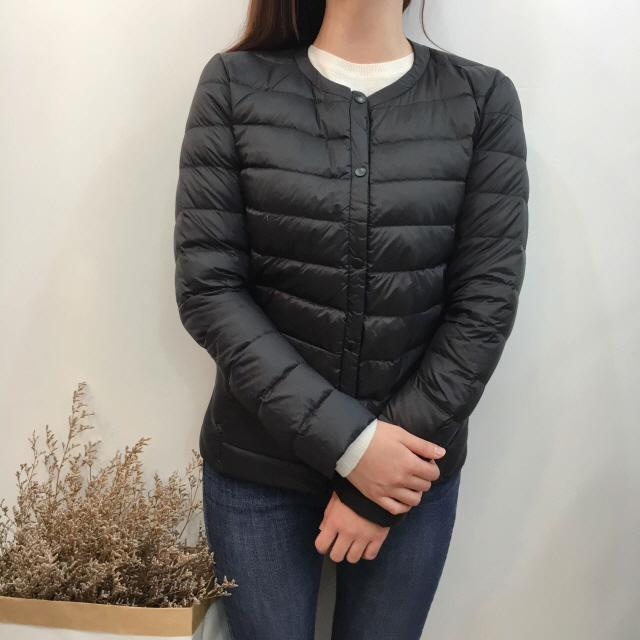

/app/workspace/data/eval//query/query_110.jpg


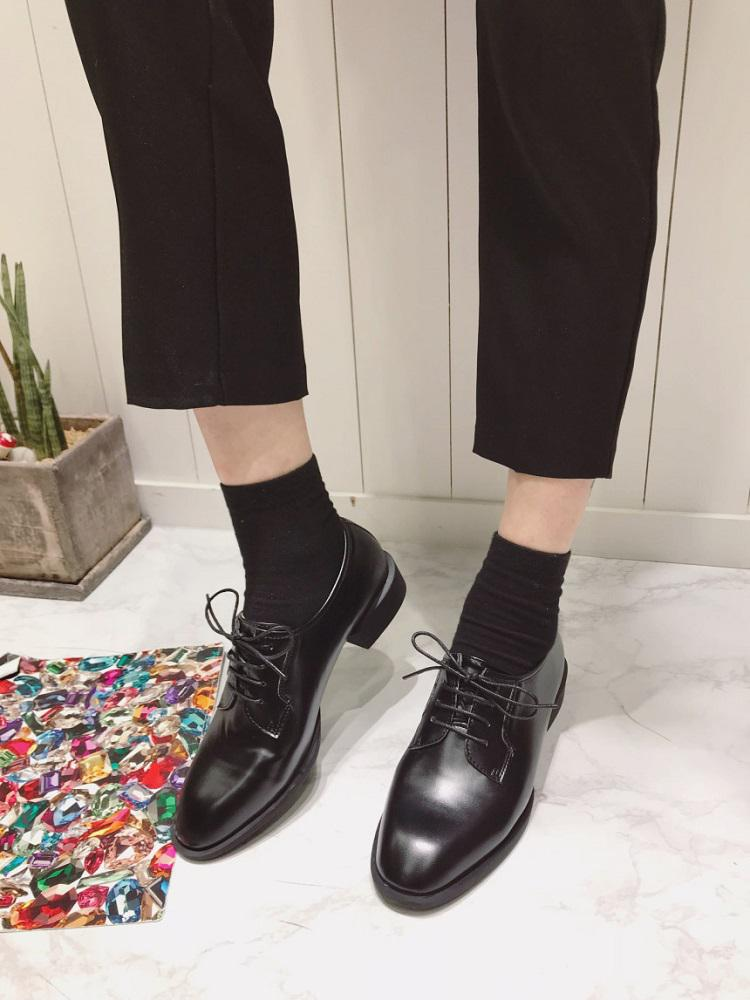

/app/workspace/data/eval//query/query_131.jpg


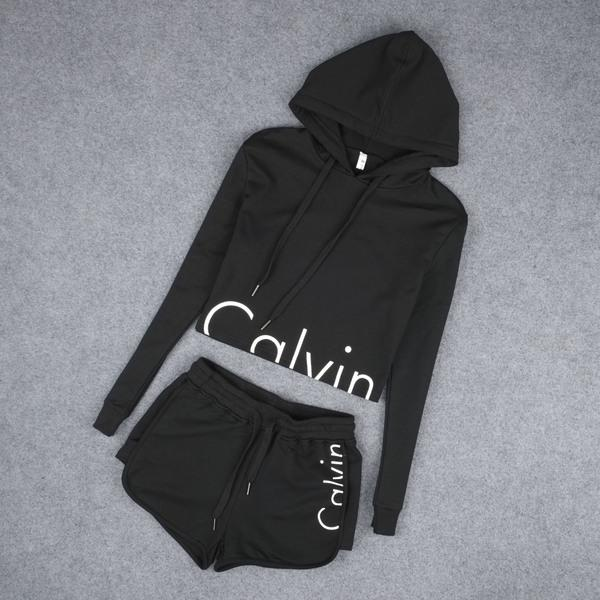

/app/workspace/data/eval//query/query_38.jpg


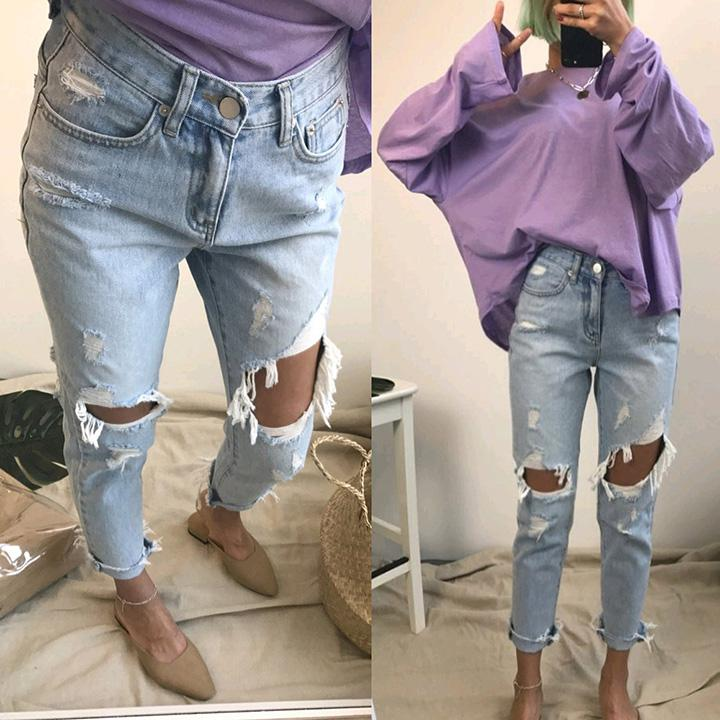

In [34]:
ct = 0
for each in glob(EVAL_ROOT_DIR + "/query/*"):
    print (each)
    display(Image2(filename=each,width=100))
    ct+=1
    if ct > 3:
        break

In [25]:
img_feature_dict = {}

In [36]:


for folder in ['compare','query']:
    idx = 0
    for each in glob(EVAL_ROOT_DIR + "/%s/*"%(folder)):        
        fname = each.split("/")[-1]
        if fname in img_feature_dict:
            continue
        try:
            idx +=1
            print(idx)
            byteImgIO = io.BytesIO()
            byteImg = Image.open(each)
            byteImg.save(byteImgIO, "PNG")
            byteImgIO.seek(0)
            byteImg = byteImgIO.read()
            dataBytesIO = io.BytesIO(byteImg)
            tens = Image.open(dataBytesIO)
            tens = Variable(trans(tens))
            tens = tens.view(1, 3, 224, 224)

            preds = nn.LogSoftmax()(res18(tens)).data.cpu().numpy()

            img_feature_dict[fname] = preds
        except Exception as e2:
            print(e2, fname)

In [13]:
import operator
from scipy.spatial.distance import cosine

### 추출된 image feature 를 활용해서 각 query 별로 가장 거리가 가까운 이미지들을 찾는다.

In [37]:
system_result_dict = {}
for each in glob(EVAL_ROOT_DIR + "/query/*"):
    
    fname = each.split("/")[-1]
    score_dict = {}
    print (each,fname)
    for other in glob(EVAL_ROOT_DIR + "/compare/*"):
        fname2 = other.split("/")[-1]
#         dist = cosine(res18_img_feature_dict[fname], res18_img_feature_dict[fname2])
        dist = cosine(img_feature_dict[fname], img_feature_dict[fname2])
#         print dist
        score_dict[fname2] = dist
#         break
    sorted_list = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=False)
    qid = fname.split("_")[-1].split(".")[0]
    system_result_dict[qid] = list(map(lambda i : i[0], sorted_list[:20]))


In [28]:
print (system_result_dict)

{'score': 0.1308126155157458}


In [18]:
TEST_ROOT_DIR = '/app/workspace/data/test160/'

### query 이미지 확인

/app/workspace/data/test160//query/query_92.jpg


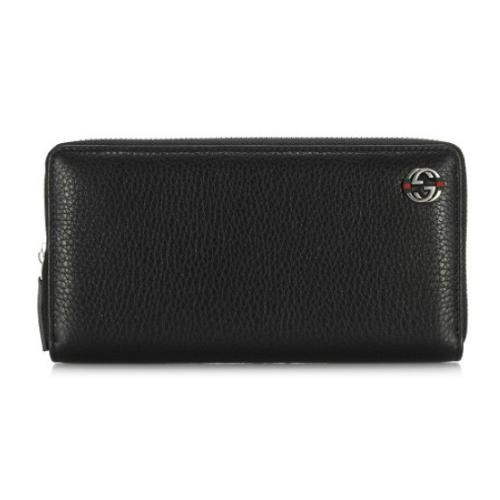

/app/workspace/data/test160//query/query_110.jpg


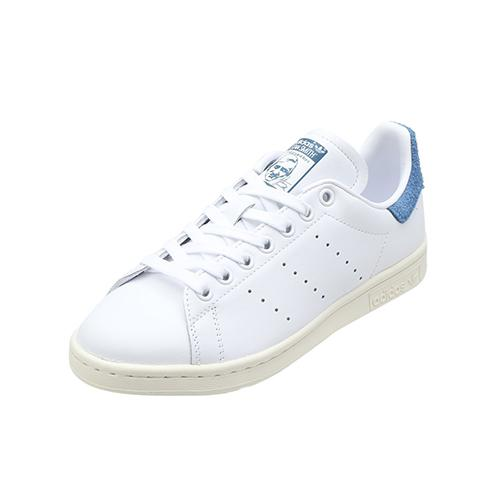

/app/workspace/data/test160//query/query_131.jpg


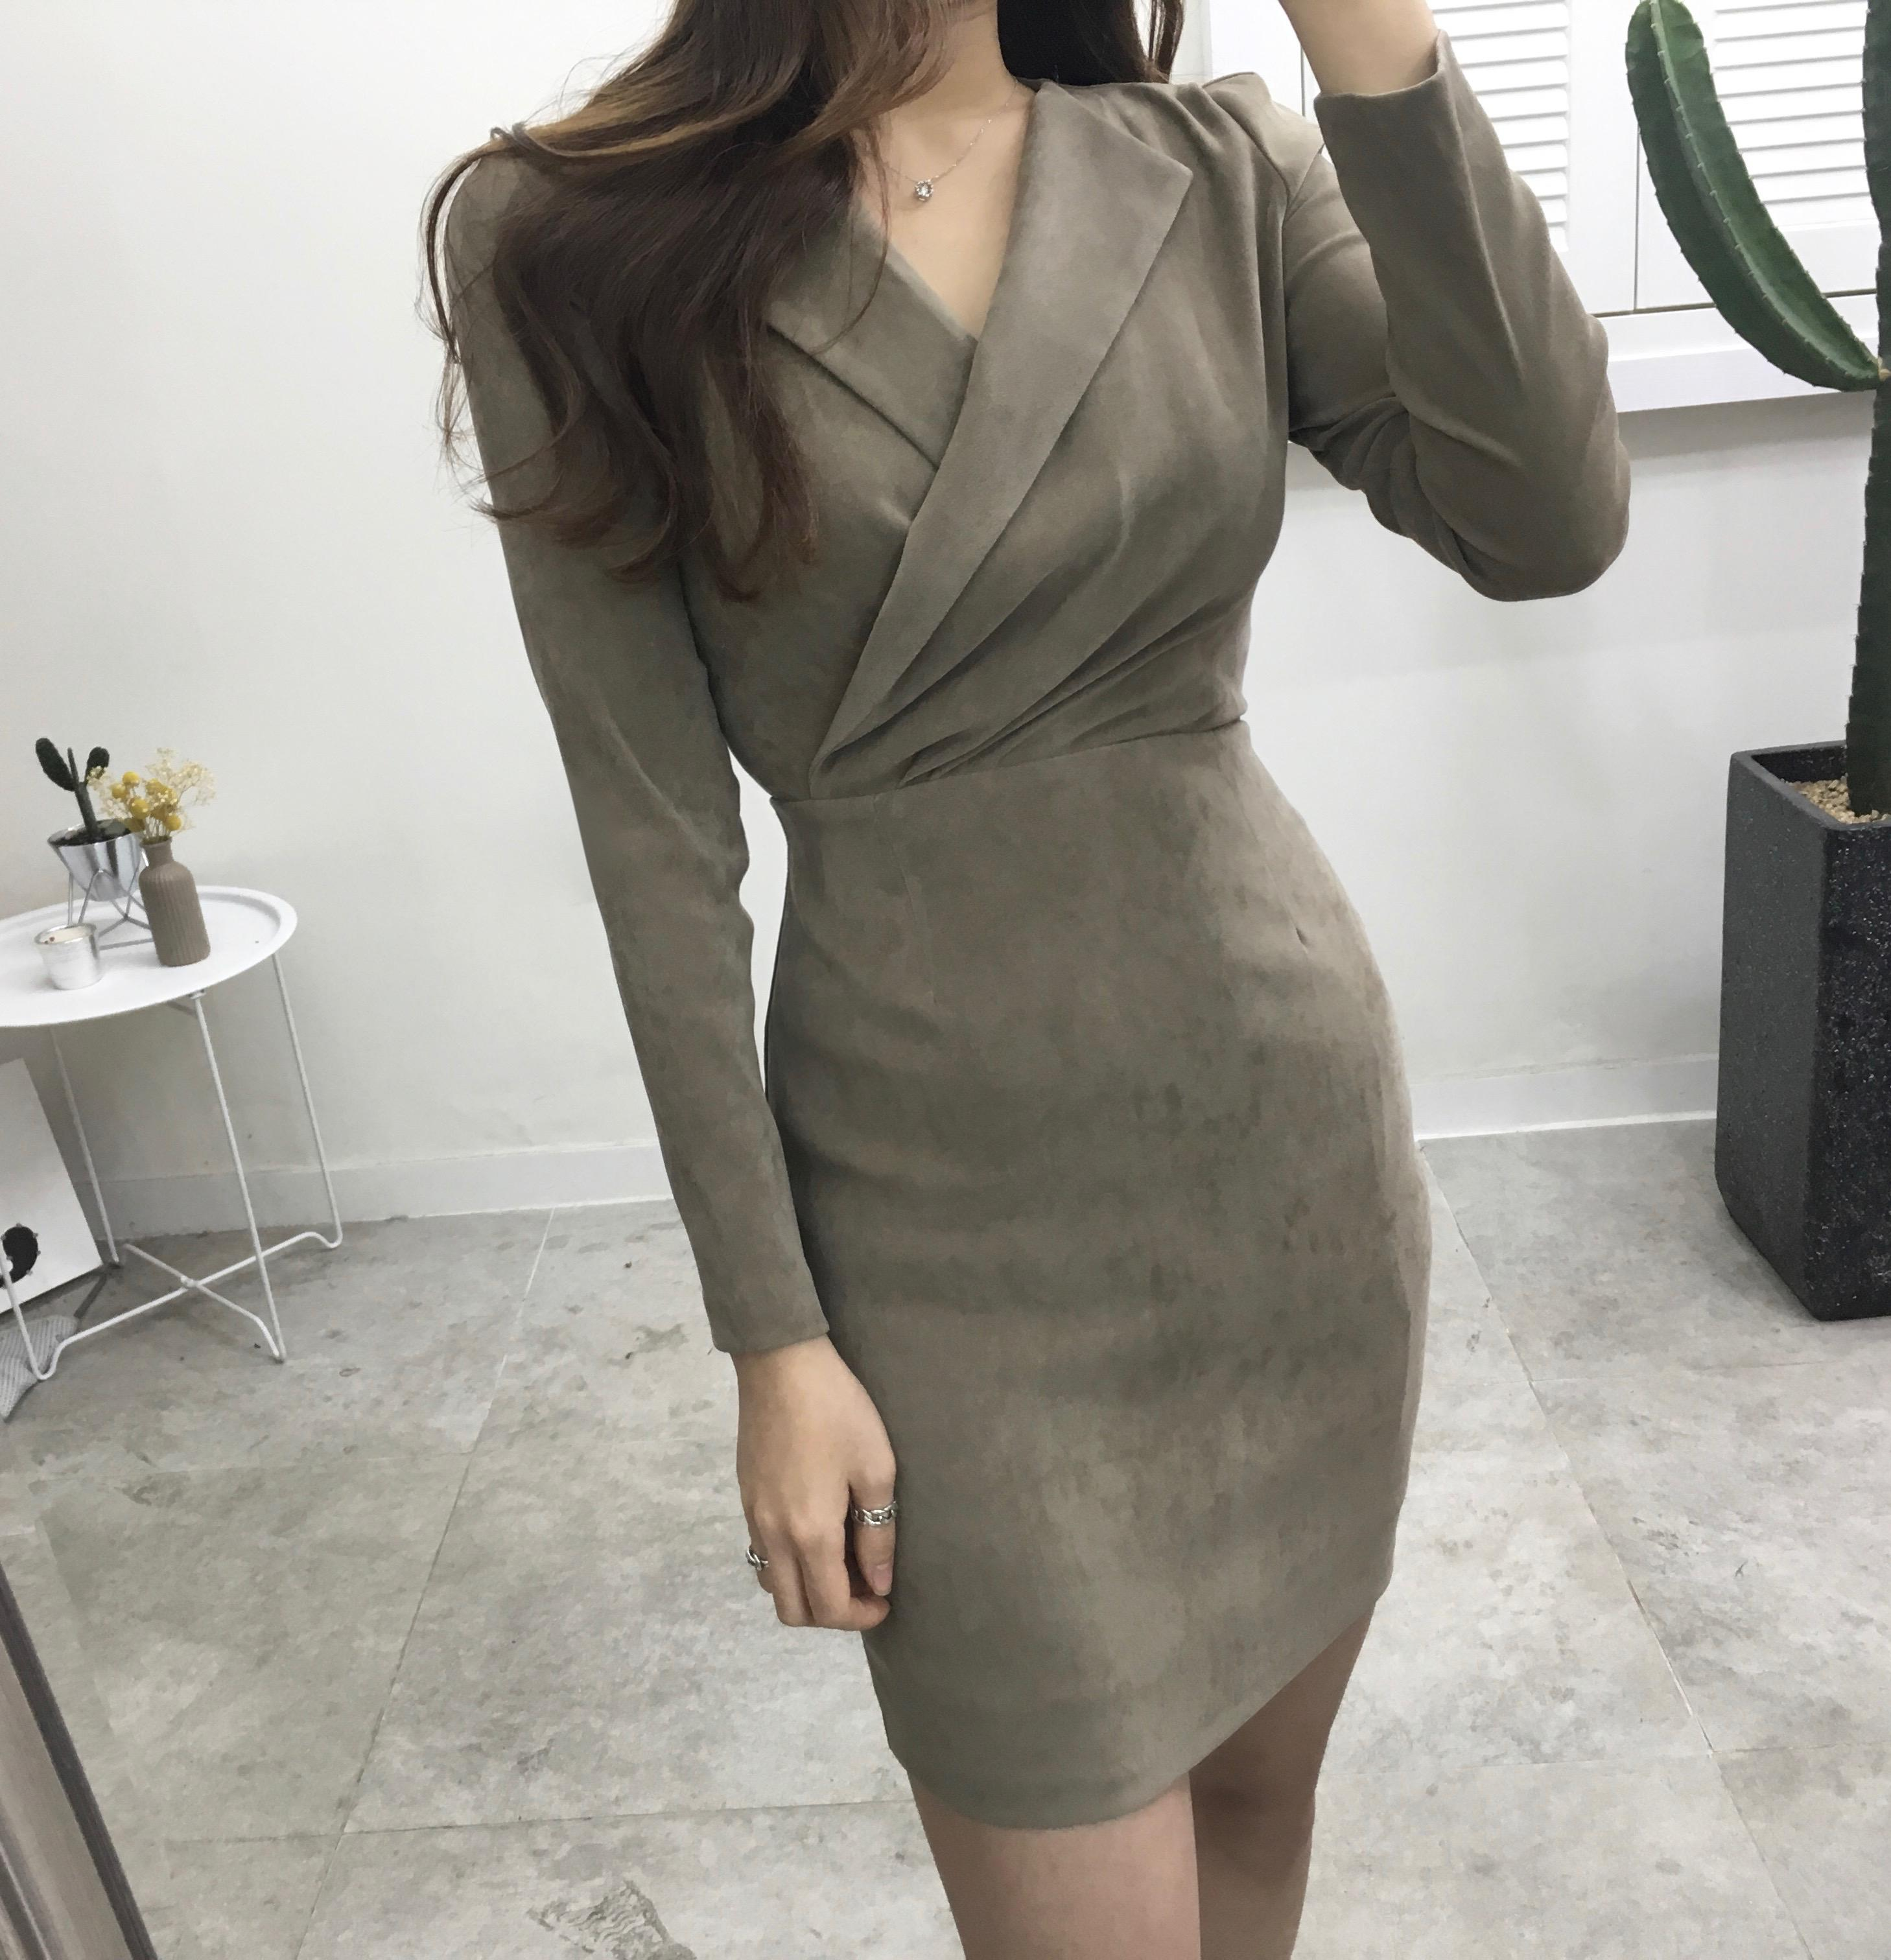

/app/workspace/data/test160//query/query_38.jpg


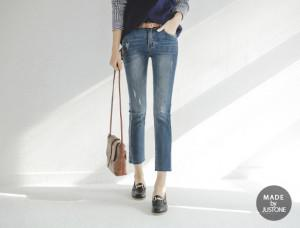

In [33]:
ct = 0
for each in glob(TEST_ROOT_DIR + "/query/*"):
    print (each)
    display(Image2(filename=each,width=100))
    ct+=1
    if ct > 3:
        break

In [17]:
img_feature_dict = {}

### Test160 데이터에 대해서 resnet18 모델을 사용해서 feature 를 추출한다.

In [29]:

for folder in ['compare','query']:
    idx = 0 
    for each in glob(TEST_ROOT_DIR + "/%s/*"%(folder)):        
        fname = each.split("/")[-1]
        idx +=1 
        if fname in img_feature_dict:
            continue
        try:
            
            print (idx)
            byteImgIO = io.BytesIO()
            byteImg = Image.open(each)
            byteImg.save(byteImgIO, "PNG")
            byteImgIO.seek(0)
            byteImg = byteImgIO.read()
            dataBytesIO = io.BytesIO(byteImg)
            tens = Image.open(dataBytesIO)
#             break
            tens = Variable(trans(tens))
            tens = tens.view(1, 3, 224, 224)

            preds = nn.LogSoftmax()(res18(tens)).data.cpu().numpy()

            img_feature_dict[fname] = preds
        except Exception as e2:
            print(e2, fname)

### 추출된 image feature 를 활용해서 각 query 별로 가장 거리가 가까운 이미지들을 찾는다.

In [38]:
system_result_dict = {}
idx = 0
for each in glob(TEST_ROOT_DIR + "/query/*"):    
    fname = each.split("/")[-1]
    score_dict = {}
    idx+=1
    print (idx, fname)    
    for other in glob(TEST_ROOT_DIR + "/compare/*"):
        fname2 = other.split("/")[-1]
        dist = cosine(img_feature_dict[fname], img_feature_dict[fname2])
        score_dict[fname2] = dist
    sorted_list = sorted(score_dict.items(), key=operator.itemgetter(1), reverse=False)
    qid = fname.split("_")[-1].split(".")[0]
    system_result_dict[qid] = list(map(lambda i : i[0], sorted_list[:20]))



In [23]:
print (system_result_dict)

{'score': 0.137554782604468}
